# 說明

### 作業的三個 Requirements
參考 Machine Learning HW3 - Image Classification (HW03.pdf)

- Easy:
    - Build a convolutional neural network using labeled images with provided codes.
    - Public simple baseline: 44.862 (accuracy, %)
- Medium:
    - Improve the performance using labeled images with different model architectures or data augmentations.
    - Public medium baseline: 52.807 (accuracy, %)
    - You can achieve the baseline by adding a few lines to the example code.(修改 ```transforms.Compose``` 處的程式碼)
- Hard:
    - Improve the performance with additional unlabeled images.
    - Public strong baseline: 82.138 (accuracy, %)
    - Do it on your own (by finishing TODO blocks in the example code).
    - Using unlabeled testing data here is allowed.
    - Hint: semi-supervised learning, self-supervised learning(修改 ```get_pseudo_labels``` 處的程式碼))

Useful Resources
- https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20%28v3%29.pdf
- https://www.youtube.com/watch?v%3DfX_guE7JNnY%26ab_channel%3DHung-yiLee

### 記憶體不足問題修正

修改所有的 ```pin_memory``` 以降低記憶體爆掉的問題。
```diff
- valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
+ valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)
```

# Easy Requirements

[官方網站說明](https://pytorch.org/vision/stable/transforms.html) 與 [官方的 ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

這裡練習怎麼使用。

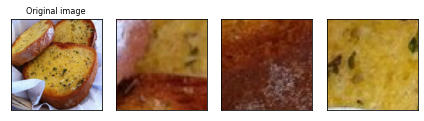

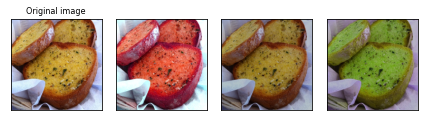

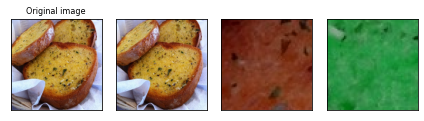

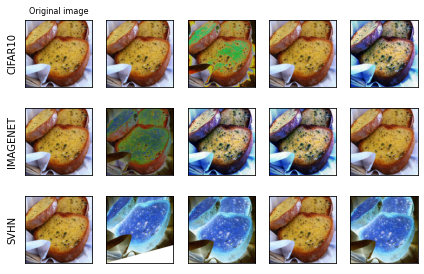

In [43]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as transforms

plt.rcParams["savefig.bbox"] = 'tight'

img_path = "food-11/training/labeled/00/0_0.jpg" # Not sure about the name of this class.
orig_img = Image.open(img_path)
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


o1 = [transforms.RandomCrop(64)(orig_img) for _ in range(3)]
plot(o1)

o2 = [transforms.ColorJitter(brightness=.5, hue=.3)(orig_img) for _ in range(3)]
plot(o2)

# 因為看起來很像發霉所以不太想要使用此功能。
# o3 = [transforms.RandomInvert()(orig_img) for _ in range(3)]
# plot(o3) 

tra = transforms.RandomApply([
    transforms.RandomCrop(64),
    transforms.ColorJitter(brightness=.5, hue=.3)
])


o4 = [tra(orig_img) for _ in range(3)]
plot(o4)

# 直接用 AutoAugment ，我懶惰。
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET, transforms.AutoAugmentPolicy.SVHN]
augmenters = [transforms.AutoAugment(policy) for policy in policies]
o5 = [[augmenter(orig_img) for _ in range(4)] for augmenter in augmenters ]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot(o5, row_title=row_title)


### 第一次 Train

使用的程式碼如下：
```python
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET, transforms.AutoAugmentPolicy.SVHN]
augmenters = [transforms.AutoAugment(policy) for policy in policies]

# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.RandomApply(augmenters, 0.8),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])
```

硬 Train 一波，結果在 HW03.ipynb 中(同個 git commit)
最終結果，跑 ```n_epochs``` = 30：
```
[ Train | 029/030 ] loss = 1.76718, acc = 0.39250
[ Valid | 028/030 ] loss = 1.56892, acc = 0.44896
```
看來只能使用簡易效果的 transforms

# Entropy-based Regularization

參考 [影片時間](https://youtu.be/fX_guE7JNnY?t=1656) 跟 [Entropy Regularization in Reinforcement Learning](https://towardsdatascience.com/entropy-regularization-in-reinforcement-learning-a6fa6d7598df)

公式：
$$
H(X) = -\sum\pi\left(x\right)\log\left(\pi\left(x\right)\right) 
$$

若是越集中在某一個 class(以機率或數值表示)，entropy 數值就會接近零。若是平均分佈，數值就會遠離零。在作業中 ```probs``` 為 Softmax 計算後的結果，數值在區間內。

In [ ]:
import numpy as np
q_1 = [0.26, 0.28, 0.24, 0.22]
h_1 = -np.sum(q_1*np.log(q_1))
print(h_1)

q_1 = [0.26, 0.28, 0.24, 0.22] * 4
h_1 = -np.sum(q_1*np.log(q_1))
print(h_1)

q_1 = [0.1, 0.08, 0.8, 0.02]
h_1 = -np.sum(q_1*np.log(q_1))
print(h_1)

q_1 = [0.5, 0.08, 0.5, 0.02]
h_1 = -np.sum(q_1*np.log(q_1))
print(h_1)

q_1 = [0.6, 0.08, 0.4, 0.02]
h_1 = -np.sum(q_1*np.log(q_1))

print(h_1)

In [ ]:
a = np.array([1,2,3,4,5])
b = a > 3
c = np.where(b)[0]
print(c)
print(type(c))

## 取出部份資料
這裡遇到了一個難題，我要怎麼取出部份資料，並且為 DataSetFolder 型態。
在 github 搜尋到 [@1am9trash](https://github.com/1am9trash/Hung_Yi_Lee_ML_2021/blob/main/hw/hw3/hw3_code.ipynb) 撰寫的程式碼，擷取實作程式碼。

```python
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]

......

    idx = []
    labels = []

    for i, batch in enumerate(data_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))
    
    dataset = PseudoDataset(Subset(dataset, idx), labels)
```

最後一段得知可以使用 [Subset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)，定睛一看發現作業本身就有寫了
```python
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
```



第一個寫法會產生奇怪的問題，改成類似於 @1am9trash 的寫法。

第一次的程式碼：
```python
class PseudogDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        ()

    def __getitem__(self, index):
        return self.x[index][0], self.y[index]

    def __len__(self):
        return len(self.y)
```

```python
    selected_indices = []
    selected_labels = []

    # Iterate over the dataset by batches.
    for i, batch in enumerate(data_loader):

        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        entropy_value = -torch.sum(probs*torch.log(probs), -1)
        selected = entropy_value < threshold
        selected[0] = True # 測試用
        selected[1] = True # 測試用

        batch_selected = torch.add(torch.where(selected)[0], i * batch_size)
        selected_indices.append(batch_selected)
        batch_label = torch.argmax(probs[selected], -1)
        selected_labels.append(batch_label)

    selected_indices = torch.cat(selected_indices)
    selected_labels = torch.cat(selected_labels).int()
    
    dataset = PseudogDataset(Subset(dataset, selected_indices), selected_labels)
```

改成以下程式碼：

```python
    entropy_value = -torch.sum(probs*torch.log(probs), -1)
            argmax = torch.argmax(probs, -1)
            for j, prob in enumerate(probs):
                if entropy_value[j] < threshold:
                # if j == 0 or j == 1:
                    selected_indices.append(i * batch_size + j)
                    selected_labels.append(int(torch.argmax(prob)))

dataset = PseudogDataset(Subset(dataset, selected_indices), selected_labels)
```

# 第一次改進

對比 [@1am9trash](https://github.com/1am9trash/Hung_Yi_Lee_ML_2021/blob/main/hw/hw3/hw3_code.ipynb) 撰寫的程式碼中的提示，要先思考 Easy, Medium 的作業要求。